In [43]:
import pandas as pd

# Predicting hotel cancelations 

- The target I will predict will be between is_canceled (0) checked out (1) canceled

- Classifications: there will be either 2 or 3 depending on the target chosen

- time-based split

- Remove arrival dates and nights stay to prevent leakage

https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [256]:
# date to index
df = pd.read_csv('https://raw.githubusercontent.com/rassamyjs/Ds20_build2/main/hotel_bookings.csv',
                 parse_dates=['reservation_status_date'],
                 index_col='reservation_status_date')

In [45]:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap
!pip install eli5
!pip install xgboost

In [93]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [257]:
def wrangle(X):
    # Make a copy
    X = X.copy()

    # Drop high cardinality cols
    high_card_cols = [col for col in X.select_dtypes('object').columns
                      if X[col].nunique() > 100]

    X.drop(columns=high_card_cols, inplace=True)

    #  Drop data leak columns
    cols = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status']
    X.drop(columns=cols, inplace=True)

    return X

In [258]:
df = wrangle(df)

Split is_canceled

In [259]:
target = 'is_canceled'
features = df.columns.drop('is_canceled')

In [30]:
# # split to train, val, test sets 
# train = df[df.index.year < 2016]
# validation = df[(df.index.year > 2015) & (df.index.year < 2017)]
# test = df[df.index.year == 2017]

# train.shape, validation.shape, test.shape

In [260]:
# split with/ time and random
train1 = df[df.index.year < 2017]
val1 = test = df[df.index.year == 2017]

target = 'is_canceled'
y = df[target]
X = df.drop(target, axis=1)

Split target vector from feature matric

In [261]:
# X_train = train[features]
# y_train = train[target]

# X_val = validation[features]
# y_val = validation[target]

# X_test = test[features]
# y_test = test[target]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train1 = train1[features]
y_train1 = train1[target]

X_val1 = val1[features]
y_val1 = val1[target]



In [262]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape)

(95512, 24) (23878, 24) (95512,) (23878,)
(82907, 24) (36483, 24) (82907,) (36483,)


baseline

In [263]:
baseline_acc1 = y_train1.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc1)
y_train1.value_counts(normalize=True)

Baseline Accuracy: 0.6010469562280628


0    0.601047
1    0.398953
Name: is_canceled, dtype: float64

- Logistic regression

- xgboost

- random forest

Does it beat your baseline?




In [264]:
# preform logistic regression time
model_log = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()



)



model_log.fit(X_train1, y_train1);

# preform logistic regression random
model_log1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()



)



model_log1.fit(X_train, y_train);

In [265]:
# check metric
print('Training Accuracy Score Time:', model_log.score(X_train1, y_train1))
print('Validation Accuracy Score Time:', model_log.score(X_val1, y_val1))


print('Training Accuracy Score Random:', model_log.score(X_train, y_train))
print('Validation Accuracy Score Random:', model_log.score(X_val, y_val))

Training Accuracy Score Time: 0.7882205362635242
Validation Accuracy Score Time: 0.7313817394402873
Training Accuracy Score Random: 0.7706361504313594
Validation Accuracy Score Random: 0.771714548957199


In [266]:
# time based split for xgboost

model_xgb1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=10)
)

model_xgb1.fit(X_train1, y_train1);

# tree time base for randomforest

model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf.fit(X_train1, y_train1);

In [267]:
# 
print('XGBoost Training Accuracy Time:', model_xgb1.score(X_train1, y_train1))
print('XGBoost Validation Accuracy Time:', model_xgb1.score(X_val1, y_val1))


#Accuracy
print('RF Training Accuracy Time:', model_rf.score(X_train1, y_train1))
print('RF Validation Accuracy Time:', model_rf.score(X_val1, y_val1))

XGBoost Training Accuracy Time: 0.8832064843740577
XGBoost Validation Accuracy Time: 0.7744154811830167
RF Training Accuracy Time: 0.987974477426514
RF Validation Accuracy Time: 0.7611490283145574


In [268]:
# random sample split for xgboost

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# tree random forest
model_rf1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf1.fit(X_train, y_train);

In [269]:
# 
print('XGBoost Training Accuracy random:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy random:', model_xgb.score(X_val, y_val))


#Accuracy
print('RF Training Accuracy random:', model_rf1.score(X_train, y_train))
print('RF Validation Accuracy random:', model_rf1.score(X_val, y_val))

XGBoost Training Accuracy random: 0.8632841946561689
XGBoost Validation Accuracy random: 0.8522489320713628
RF Training Accuracy random: 0.9875931820085434
RF Validation Accuracy random: 0.8643940028478097


## Visual graphs

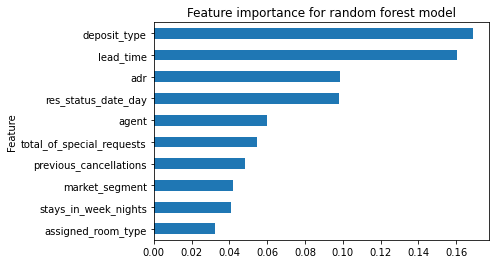

In [251]:
# feature importances

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('')
plt.ylabel('Feature')
plt.title('Feature importance for random forest model');

In [253]:
# get permutation importances

perm_imp = permutation_importance(model_rf1, X_val, y_val, n_jobs=10, random_state=42)

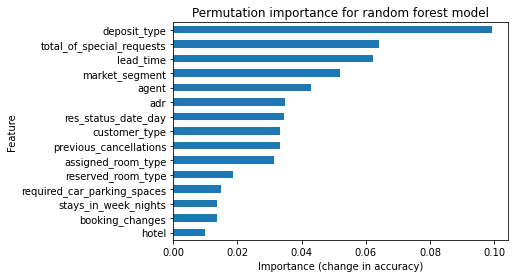

In [254]:

# Put results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df1 = pd.DataFrame(data, index=X_val.columns)
df1.sort_values('importances_mean', ascending=True, inplace=True)

# Make plot
df1['importances_mean'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for random forest model');

In [255]:
df['deposit_type'].value_counts()

No Deposit    104641
Non Refund     14587
Refundable       162
Name: deposit_type, dtype: int64

In [ ]:
X_val.columns

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


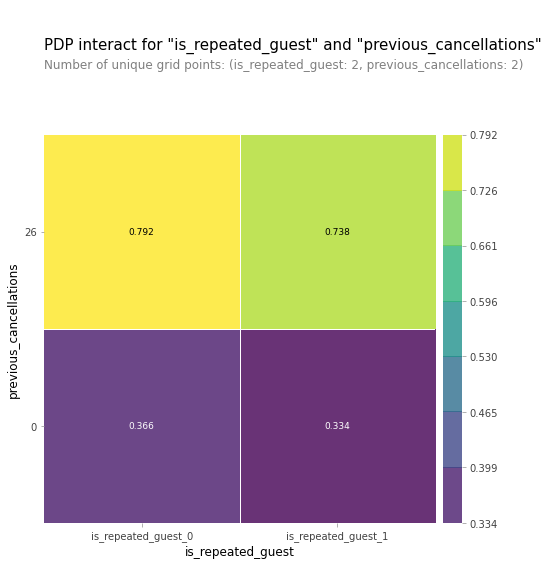

In [82]:
features = ['is_repeated_guest', 'previous_cancellations']

interact = pdp_interact(
    model=model_rf1,
    dataset=X_val, # <-- use validation data
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

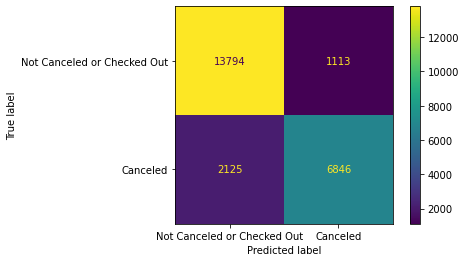

In [75]:
plot_confusion_matrix(model_rf1, X_val, y_val, # <-- Use validation data
                      values_format='.0f',
                      display_labels=['Not Canceled or Checked Out', 'Canceled']);

## Second Wrangle

- add pandemic column 

In [143]:
# def wrangle1(X1):


#     # Drop high cardinality cols
#     high_card_cols = [col for col in X1.select_dtypes('object').columns
#                       if X1[col].nunique() > 100]

#     X1.drop(columns=high_card_cols, inplace=True)
    
#     #to datetime
#     X1['reservation_status_date'] = pd.to_datetime(X1.reservation_status_date)

#     X1['res_status_date_day'] = X1['reservation_status_date'].dt.day
#     X1['res_status_date_dayofweek'] = X1['reservation_status_date'].dt.dayofweek
#     X1['res_status_date_month'] = X1['reservation_status_date'].dt.month
#     X1['res_status_date_year'] = X1['reservation_status_date'].dt.year
#     # arrival date months to int
    
#     X1['arrival_date_month'] = X1['arrival_date_month'].replace({'January':1,
#                                                               'February':2,
#                                                               'March':3,
#                                                               'April':4,
#                                                               'May':5,
#                                                               'June':6,
#                                                               'July':7,
#                                                               'August':8,
#                                                               'September':9,
#                                                               'October':10,
#                                                               'November':11,
#                                                               'December':12}) 


#      #Drop data leak columns
#     cols = ['reservation_status_date', 'reservation_status']
#     X1.drop(columns=cols, inplace=True)

#     return X1

In [439]:
df2 = pd.read_csv('https://raw.githubusercontent.com/rassamyjs/Ds20_build2/main/hotel_bookings.csv',
                 )


In [440]:
#to datetime
df2['reservation_status_date'] = pd.to_datetime(df2.reservation_status_date)

df2['res_status_date_day'] = df2['reservation_status_date'].dt.day
df2['res_status_date_dayofweek'] = df2['reservation_status_date'].dt.dayofweek
df2['res_status_date_month'] = df2['reservation_status_date'].dt.month
df2['res_status_date_year'] = df2['reservation_status_date'].dt.year

df2.set_index(['reservation_status_date'], inplace=True)

In [441]:
# add pandemic as feature
df2['pandemic'] = df2['res_status_date_year']


In [442]:
# say 2016 is 2020 when the lockdown occured
# 2017 - 2021 future prediction
df2['pandemic'] = df2['pandemic'].replace({2014:0,
                         2015:0,
                        2016:1,
                        2017:1})


In [443]:
df2['pandemic'].value_counts()

1    94280
0    25110
Name: pandemic, dtype: int64

In [444]:
df2['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [445]:
# say around april-july people canceled bookings because of covid
df2.loc['2016-04-01':'2016-07-31', 'is_canceled'] = 1

In [446]:
df2['is_canceled'].value_counts()

0    61978
1    57412
Name: is_canceled, dtype: int64

In [448]:
def wrangle(X):
    # Make a copy
    X = X.copy()

    # Drop high cardinality cols
    high_card_cols = [col for col in X.select_dtypes('object').columns
                      if X[col].nunique() > 100]

    X.drop(columns=high_card_cols, inplace=True)

    #  Drop data leak columns
    cols = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number',
            'arrival_date_day_of_month', 'reservation_status', 'res_status_date_year',
           'res_status_date_month', 'res_status_date_dayofweek', 'res_status_date_day']
    X.drop(columns=cols, inplace=True)

    return X

In [449]:
df2 = wrangle(df2)

In [450]:

target = 'is_canceled'
features = df2.columns.drop('is_canceled')

# split with/ time and random
train1 = df2[df2.index.year < 2017]
val1 = test = df2[df2.index.year == 2017]

target = 'is_canceled'
y = df2[target]
X = df2.drop(target, axis=1)


In [451]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train1 = train1[features]
y_train1 = train1[target]

X_val1 = val1[features]
y_val1 = val1[target]



In [452]:
baseline_acc1 = y_train1.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc1)
y_train1.value_counts(normalize=True)

Baseline Accuracy: 0.5580228448743774


1    0.558023
0    0.441977
Name: is_canceled, dtype: float64

In [453]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape



((95512, 25), (23878, 25), (95512,), (23878,))

In [454]:
X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape


((82907, 25), (36483, 25), (82907,), (36483,))

In [455]:
# preform logistic regression time
model_log = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()



)



model_log.fit(X_train1, y_train1);

# preform logistic regression random
model_log1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()



)



model_log1.fit(X_train, y_train);

In [456]:
# check metric
print('Training Accuracy Score Time:', model_log.score(X_train1, y_train1))
print('Validation Accuracy Score Time:', model_log.score(X_val1, y_val1))


print('Training Accuracy Score Random:', model_log.score(X_train, y_train))
print('Validation Accuracy Score Random:', model_log.score(X_val, y_val))

Training Accuracy Score Time: 0.7020758198945807
Validation Accuracy Score Time: 0.5463914699997259
Training Accuracy Score Random: 0.6541481698634727
Validation Accuracy Score Random: 0.6559175810369378


In [457]:
# tree random forest
model_rf1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf1.fit(X_train, y_train);


model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf.fit(X_train1, y_train1);



In [458]:
#Accuracy
print('RF Training Accuracy Time:', model_rf.score(X_train1, y_train1))
print('RF Validation Accuracy Time:', model_rf.score(X_val1, y_val1))

#Accuracy
print('RF Training Accuracy random:', model_rf1.score(X_train, y_train))
print('RF Validation Accuracy random:', model_rf1.score(X_val, y_val))


RF Training Accuracy Time: 0.990676299950547
RF Validation Accuracy Time: 0.6105857522681797
RF Training Accuracy random: 0.9892893039618058
RF Validation Accuracy random: 0.8197085183013653


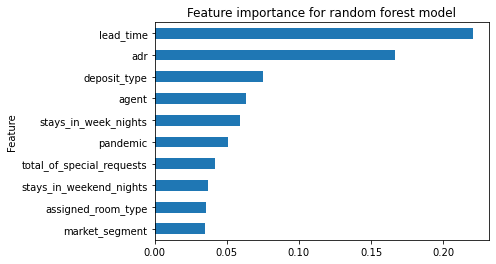

In [459]:
# feature importances

importances = model_rf.named_steps['randomforestclassifier'].feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('')
plt.ylabel('Feature')
plt.title('Feature importance for random forest model');

In [460]:
# get permutation importances

perm_imp = permutation_importance(model_rf1, X_val, y_val, n_jobs=10, random_state=42)

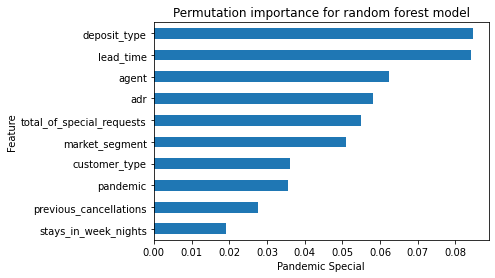

In [461]:

# Put results into DataFrame
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df1 = pd.DataFrame(data, index=X_val.columns)
df1.sort_values('importances_mean', ascending=True, inplace=True)

# Make plot
df1['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Pandemic Special')
plt.ylabel('Feature')
plt.title('Permutation importance for random forest model');

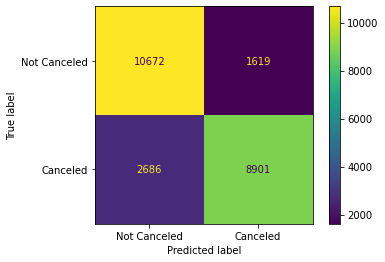

In [464]:
plot_confusion_matrix(model_rf1, X_val, y_val, # <-- Use validation data
                      values_format='.0f',
                      display_labels=['Not Canceled', 'Canceled']);

In [463]:
df2.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,pandemic
reservation_status_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,0,0,2,0.0,0,BB,Direct,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,0
2015-07-01,Resort Hotel,0,737,0,0,2,0.0,0,BB,Direct,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,0
2015-07-02,Resort Hotel,0,7,0,1,1,0.0,0,BB,Direct,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,0
2015-07-02,Resort Hotel,0,13,0,1,1,0.0,0,BB,Corporate,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,0
2015-07-03,Resort Hotel,0,14,0,2,2,0.0,0,BB,Online TA,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,0
